In [1]:
import os
os.listdir()

['.config',
 'synthetic_chat_logs_with_sentiment.json',
 'cloud-computing-project-cb32f-firebase-adminsdk-fbsvc-4e9abde912.json',
 'sample_data']

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import length, col, collect_set

In [3]:
spark = SparkSession.builder.appName("ChatLogProcessing").getOrCreate()

In [4]:
df = spark.read.option("multiline", "true").json("synthetic_chat_logs_with_sentiment.json")
df.show(5, truncate=False)

+--------------+---------+------------------------------------------------+
|intent        |sentiment|text                                            |
+--------------+---------+------------------------------------------------+
|return_request|negative |Can you help me return this product?            |
|product_issue |negative |The charger isn’t functioning properly.         |
|return_request|negative |This isn’t what I expected, I want to return it.|
|return_request|negative |How do I send this back?                        |
|thank_you     |positive |I appreciate your help.                         |
+--------------+---------+------------------------------------------------+
only showing top 5 rows



In [5]:
df = df.dropna()

In [6]:
df = df.filter(length(col("text")) > 5)

In [7]:
from pyspark.sql.functions import regexp_replace

df = df.withColumn("clean_text", regexp_replace("text", "[^a-zA-Z0-9\s]", ""))

In [8]:
from pyspark.sql.functions import lower

df = df.withColumn("clean_text", lower(col("clean_text")))

In [9]:
df.show(5, truncate=False)

+--------------+---------+------------------------------------------------+---------------------------------------------+
|intent        |sentiment|text                                            |clean_text                                   |
+--------------+---------+------------------------------------------------+---------------------------------------------+
|return_request|negative |Can you help me return this product?            |can you help me return this product          |
|product_issue |negative |The charger isn’t functioning properly.         |the charger isnt functioning properly        |
|return_request|negative |This isn’t what I expected, I want to return it.|this isnt what i expected i want to return it|
|return_request|negative |How do I send this back?                        |how do i send this back                      |
|thank_you     |positive |I appreciate your help.                         |i appreciate your help                       |
+--------------+--------

In [10]:
from pyspark.sql.functions import size, split

df = df.withColumn("text_length", size(split("clean_text", " ")))
df.select("clean_text", "text_length").show(truncate=False)

+---------------------------------------------+-----------+
|clean_text                                   |text_length|
+---------------------------------------------+-----------+
|can you help me return this product          |7          |
|the charger isnt functioning properly        |5          |
|this isnt what i expected i want to return it|10         |
|how do i send this back                      |6          |
|i appreciate your help                       |4          |
|the screen was cracked when i opened the box |9          |
|i need to cancel my order                    |6          |
|i need a refund for my purchase              |7          |
|how do i send this back                      |6          |
|this isnt what i expected i want to return it|10         |
|i need to talk to support                    |6          |
|thanks a lot                                 |3          |
|i ordered 3 days ago and its still not here  |10         |
|hi can you tell me where my order is   

In [11]:
df_filtered = df.filter(df["text_length"] >= 3)

In [12]:
#Group intent and associated sentiment
intent_sentiment_df = df_filtered.groupBy("intent").agg(collect_set("sentiment").alias("associated_sentiments"))
intent_sentiment_pd = intent_sentiment_df.toPandas()

print(intent_sentiment_pd)

           intent associated_sentiments
0  return_request            [negative]
1    order_status             [neutral]
2        greeting             [neutral]
3    cancel_order            [negative]
4   product_issue            [negative]
5       thank_you            [positive]


In [13]:
from pyspark.sql.functions import desc

intent_counts = df_filtered.groupBy("intent").count().orderBy(desc("count"))
intent_counts.show()

+--------------+-----+
|        intent|count|
+--------------+-----+
|  cancel_order|   58|
| product_issue|   56|
|return_request|   52|
|     thank_you|   45|
|  order_status|   43|
|      greeting|   39|
+--------------+-----+



In [14]:
sentiment_counts = df_filtered.groupBy("sentiment").count().orderBy(desc("count"))
sentiment_counts.show()

+---------+-----+
|sentiment|count|
+---------+-----+
| negative|  166|
|  neutral|   82|
| positive|   45|
+---------+-----+



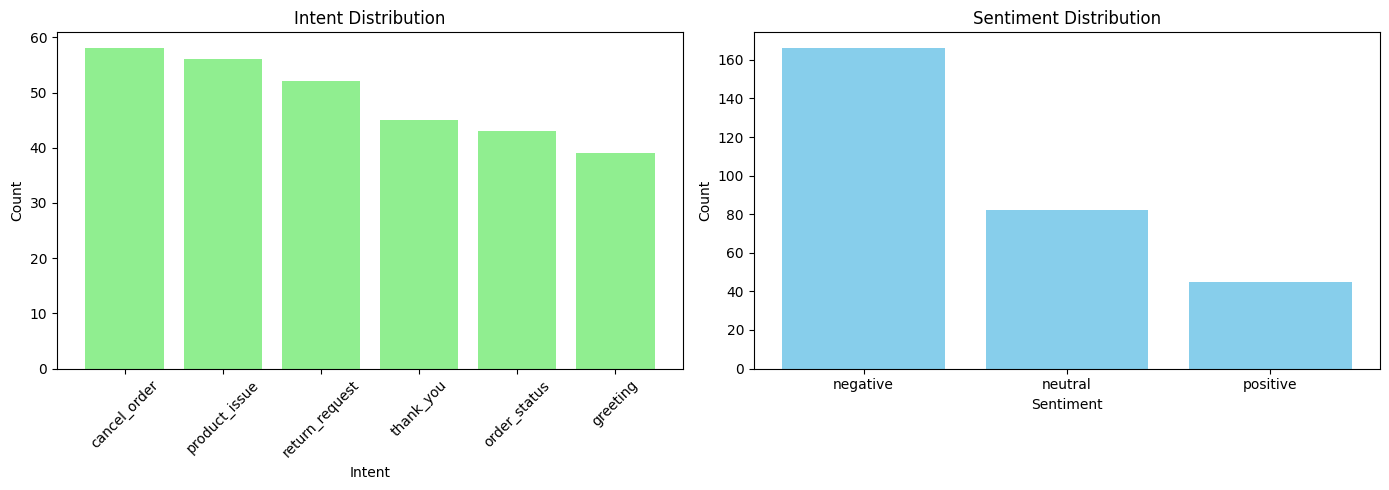

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14, 5))
intent_pd = intent_counts.toPandas()
plt.subplot(1, 2, 1)
plt.bar(intent_pd["intent"], intent_pd["count"], color='lightgreen')
plt.title("Intent Distribution")
plt.xlabel("Intent")
plt.ylabel("Count")
plt.xticks(rotation=45)
sentiment_pd = sentiment_counts.toPandas()
plt.subplot(1, 2, 2)
plt.bar(sentiment_pd["sentiment"], sentiment_pd["count"], color='skyblue')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [16]:
pandas_df = df.select("clean_text", "intent","sentiment").toPandas()

In [17]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(oov_token="unknown")
tokenizer.fit_on_texts(pandas_df["clean_text"])

sequences = tokenizer.texts_to_sequences(pandas_df["clean_text"])
padded = pad_sequences(sequences, padding='post')

In [18]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
intent_labels = label_encoder.fit_transform(pandas_df["intent"])

In [19]:
sentiment_encoder = LabelEncoder()
sentiment_labels = sentiment_encoder.fit_transform(pandas_df["sentiment"])

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_intent_train, y_intent_test, y_sentiment_train, y_sentiment_test = train_test_split(padded, intent_labels, sentiment_labels, test_size=0.2, random_state=42)

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense,Bidirectional

In [22]:
input_layer = Input(shape=(padded.shape[1],))
x = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64)(input_layer)
x = Bidirectional(LSTM(64))(x)
intent_output = Dense(len(label_encoder.classes_), activation='softmax', name='intent_output')(x)
sentiment_output = Dense(len(sentiment_encoder.classes_), activation='softmax', name='sentiment_output')(x)
model = Model(inputs=input_layer, outputs=[intent_output, sentiment_output])
model.compile(
    optimizer='adam',
    loss={
        'intent_output': 'sparse_categorical_crossentropy',
        'sentiment_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'intent_output': 'accuracy',
        'sentiment_output': 'accuracy'
    }
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 10, 64)    │      6,720 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     66,048 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ intent_output       │ (None, 6)         │        774 │ bidirectional[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sentiment_output    │ (None, 3)         │        387 │ bidirectional[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,929 (288.79 KB)

 Trainable params: 73,929 (288.79 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
history = model.fit(
    X_train,
    [y_intent_train, y_sentiment_train],
    validation_split=0.2,
    epochs=10,
    batch_size=32
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 6s 178ms/step - intent_output_accuracy: 0.1522 - intent_output_loss: 1.7875 - loss: 2.8724 - sentiment_output_accuracy: 0.4732 - sentiment_output_loss: 1.0849 - val_intent_output_accuracy: 0.2917 - val_intent_output_loss: 1.7670 - val_loss: 2.8097 - val_sentiment_output_accuracy: 0.5625 - val_sentiment_output_loss: 1.0430
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - intent_output_accuracy: 0.2952 - intent_output_loss: 1.7568 - loss: 2.7937 - sentiment_output_accuracy: 0.5349 - sentiment_output_loss: 1.0369 - val_intent_output_accuracy: 0.3333 - val_intent_output_loss: 1.7342 - val_loss: 2.7089 - val_sentiment_output_accuracy: 0.5625 - val_sentiment_output_loss: 0.9796
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - intent_output_accuracy: 0.3514 - intent_output_loss: 1.7158 - loss: 2.6917 - sentiment_output_accuracy: 0.5269 - sentiment_output_loss: 0.9759 - val_intent_output_accuracy: 0.3333 - val_intent_output_loss: 1.6772 - val_loss: 2.546

In [24]:
model.evaluate(X_test, [y_intent_test, y_sentiment_test])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - intent_output_accuracy: 1.0000 - intent_output_loss: 0.3561 - loss: 0.4139 - sentiment_output_accuracy: 1.0000 - sentiment_output_loss: 0.0612


[0.4379032254219055, 0.3722001910209656, 0.07085061073303223, 1.0, 1.0]

##Classify Responses

In [25]:
def classify(message):
    seq = tokenizer.texts_to_sequences([message])
    pad = pad_sequences(seq, maxlen=padded.shape[1], padding='post')
    intent_pred, sentiment_pred = model.predict(pad)
    intent_label = label_encoder.inverse_transform([intent_pred.argmax()])
    sentiment_label = sentiment_encoder.inverse_transform([sentiment_pred.argmax()])
    return intent_label[0], sentiment_label[0]

In [26]:
test_messages = [
    "I want to cancel my order please.",
    "Thanks a lot for your help!",
    "When is my package arriving?",
    "The screen is cracked.",
    "hello",
    "I need help",
    "how to fix this?",
    "Return this product immediately!"
]

for msg in test_messages:
    intent, sentiment = classify(msg)
    print(f"Message: {msg}\n→ Intent: {intent}, Sentiment: {sentiment}\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
Message: I want to cancel my order please.
→ Intent: cancel_order, Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Message: Thanks a lot for your help!
→ Intent: thank_you, Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Message: When is my package arriving?
→ Intent: order_status, Sentiment: neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Message: The screen is cracked.
→ Intent: thank_you, Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Message: hello
→ Intent: greeting, Sentiment: positive

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Message: I need help
→ Intent: thank_you, Sentiment: neutral

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Message: how to fix this?
→ Intent: greeting, Sentiment: negative

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Message: Return this product immediately!
→ Intent: product_issue, Sentiment: negative



In [27]:
loss, intent_loss, sentiment_loss, intent_acc, sentiment_acc = model.evaluate(
    X_test, [y_intent_test, y_sentiment_test], verbose=0
)

print(f"Test Accuracy for Intent: {intent_acc:.2f}")
print(f"Test Accuracy for Sentiment: {sentiment_acc:.2f}")


Test Accuracy for Intent: 1.00
Test Accuracy for Sentiment: 1.00


#Save responses in Firebase

In [34]:
#To save messages in firebase

import uuid
from datetime import datetime

user_id = "user9" #default should be changed later

def store_message(user_id, sender, message):

  message_ref = db.collection("users").document(user_id).collection("chat_history").document(str(uuid.uuid4()))
  message_ref.set({
      "sender": sender,
      "message": message,
      "timestamp": datetime.utcnow()
    })

In [29]:
import firebase_admin
from firebase_admin import credentials, firestore

In [30]:
# Load service account key
cred = credentials.Certificate("/content/cloud-computing-project-cb32f-firebase-adminsdk-fbsvc-4e9abde912.json")

if not firebase_admin._apps:
    firebase_admin.initialize_app(cred)
    print("Firebase app initialized.")
else:
    print("Firebase app already initialized.")

Firebase app initialized.


In [31]:
# Initialize Firestore
db = firestore.client()

###Enhance Chatbot Response by Rule-based Approach

In [32]:
def generate_rule_based_response(predicted_sentiment, predicted_intent):
  response = "I'm sorry, I didn't understand that."

  if predicted_sentiment == "negative":
    if predicted_intent == "request_return":
      response = "Please wait a moment. You're redirected to a live agent to request a return for your product."
    elif predicted_intent == "cancel_order":
      response = "Please wait a moment. You're redirected to a live agent to cancel your order."
    elif predicted_intent == "product_issue":
      response = "Please wait a moment. You're redirected to a live agent to help with your product issue."
  elif predicted_sentiment == "neutral":
    if predicted_intent == "greeting":
      response = "Hello! How can I assist you today?"
    elif predicted_intent == "order_status":
      response = "Your order is ..."
  elif predicted_sentiment == "positive":
    response = "Thank you for your feedback!"

  return response

def generate_rule_based_response_chatbot(user_input):

    predicted_intent, predicted_sentiment = classify(user_input)

    # Generate response based on predicted sentiment using rule-based approach
    response = generate_rule_based_response(predicted_sentiment, predicted_intent)

    return response

def generate_pattern_response(user_input):
  user_input = user_input.lower().strip()  # Normalize input

  patterns = {
      "hello": "Hello! How can I assist you today?",
      "help": "Sure, I'd be happy to help. What do you need assistance with?",
      "bye": "Goodbye! If you have more questions in the future, feel free to ask.",
      "are you": "I'm a chatbot, ready to assist you with what you need!",
      "thank": "You're welcome! If you have any other questions, feel free to ask.",
      "working hours": "We're available 24 hours for help!",
      "ok": "Great! If you have any other questions, feel free to ask.",
      "your name": "I'm a chatbot."
  }

  for pattern, response in patterns.items():
    if pattern in user_input.lower():
      return response

  # If no pattern matches, use the rule-based response based on sentiment
  return generate_rule_based_response_chatbot(user_input)

In [35]:
while True:
    user_input = input("You: ")
    store_message(user_id, "user", user_input)

    if user_input.lower() == "exit":
        print("Bot: Goodbye!")
        break
    bot_response = generate_pattern_response(user_input)
    print("Bot:", bot_response)
    store_message(user_id, "bot", bot_response)

You: hello
Bot: Hello! How can I assist you today?
You: exit
Bot: Goodbye!
